<br>

<center>
    <span style="font-size:24px; font-weight:bold;">Tesla Stock Prediction - RNN Time Series</span>
</center>

<br>

<hr style="border: none; border-top: 1px solid #000;">

<center>
    <span>
        Created by <b>Ian Yap</b>
        &emsp;|&emsp;
        Data from <a href="https://finance.yahoo.com/quote/TSLA/history"><b>Yahoo Finance</b></a>
        &nbsp;
    </span>
</center>

<br>

<center>
    <span>
        <a href="https://www.linkedin.com/in/ian-yap-052870139/"><b>LinkedIn</b></a>
        &emsp;|&emsp;
        <a href="https://xiyap.github.io/"><b>Portfolio</b></a>
    </span>
</center>
    
<hr style="border: none; border-top: 1px solid #000;">


<span style="font-size:24px; font-weight:bold; text-decoration:underline;">Background</span>

In this rapidly advancing era of Artificial Intelligence, one of the most coveted applications is stock prediction. An AI model capable of forecasting future stock prices would bring unprecedented wealth even for individuals lacking expertise in trading. Although theoretically this should not be possible due to the random nature of the stock market, which could be easily influenced by external factors such as market and investor sentiment, government regulation changes, geopolitical events and natural disasters, we will attempt to create a model to explore on this topic.

<span style="font-size:24px; font-weight:bold; text-decoration:underline;">Objective</span>

The *main* objective of this project is to **develop a predictive model which can predict future stock price of Tesla (TSLA), an American Automotive Company.**

<span style="font-size:24px; font-weight:bold; text-decoration:underline;">Feature Information</span>

- **Date**: Date of trading
- **Open**: Price at which the first trade occurs when market opens
- **High**: Highest price during trading period
- **Low**: Lowest price during trading period
- **Close**: Price at which the last trade occurs when market opens
- **Adj Close**: Closing prices adjusted for factors such as dividends, stock splits etc.
- **Volume**: Total number of shares traded during trading period

<span style="font-size:24px; font-weight:bold; text-decoration:underline;">Import Libraries</span>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
import random

seed = 101
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

<span style="font-size:24px; font-weight:bold; text-decoration:underline;">Data Loading</span>

Loading the data to be used for analysis and model development.

In [3]:
df_ori = pd.read_csv('TSLA.csv')

In [4]:
df = df_ori.copy()

In [5]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [6]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


<span style="font-size:24px; font-weight:bold; text-decoration:underline;">Feature Engineering</span>

Before using the data, we will perform data wrangling to clean the data so that it is suitable for the predictive model.

We first check for any duplicated data and remove them as it will affect the data analysis and training of the predictive model.

In [7]:
print(f'Number of duplicated rows: {df.duplicated().sum()}')

Number of duplicated rows: 0


Next, we will check the shape of the data and its status.

Looks like our data has 3439 rows, 7 columns, no missing data and the data types of each attributes are correct aside from the date.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3439 entries, 0 to 3438
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3439 non-null   object 
 1   Open       3439 non-null   float64
 2   High       3439 non-null   float64
 3   Low        3439 non-null   float64
 4   Close      3439 non-null   float64
 5   Adj Close  3439 non-null   float64
 6   Volume     3439 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 188.2+ KB


In [9]:
missing_value = df.isna().sum()
missing_value_percentage = (missing_value / len(df)) * 100

pd.DataFrame({'Total Missing Value': missing_value, 'Missing Percentage': missing_value_percentage})

,Total Missing Value,Missing Percentage
Date,0,0.0
Open,0,0.0
High,0,0.0
Low,0,0.0
Close,0,0.0
Adj Close,0,0.0
Volume,0,0.0


Now that the data is clean, we can explore the data using descriptive statistics to gain insights on the data.

In [10]:
cat_col = df.select_dtypes(include = 'object').describe()
cat_col

,Date
count,3439
unique,3439
top,2010-06-29
freq,1


Convert date into datetime objects:

In [11]:
df['Date'] = df['Date'].str.split(' ', expand = True)[0]
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

Calculate moving average:

In [12]:
moving_average = [5, 50, 100]
for days in moving_average:
    MA_column_name = f'{days} days moving average'
    df[MA_column_name] = df['Close'].rolling(window = days).mean()

In [13]:
df.head(10)

,Open,High,Low,Close,Adj Close,Volume,5 days moving average,50 days moving average,100 days moving average
Date,,,,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500,NaN,NaN,NaN
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500,NaN,NaN,NaN
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000,NaN,NaN,NaN
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000,NaN,NaN,NaN
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500,1.399867,NaN,NaN
2010-07-07,1.093333,1.108667,0.998667,1.053333,1.053333,103825500,1.292000,NaN,NaN
2010-07-08,1.076000,1.168000,1.038000,1.164000,1.164000,115671000,1.207067,NaN,NaN
2010-07-09,1.172000,1.193333,1.103333,1.160000,1.160000,60759000,1.146267,NaN,NaN
2010-07-12,1.196667,1.204667,1.133333,1.136667,1.136667,33037500,1.117600,NaN,NaN


In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,3439.0,7.201986e+01,1.020046e+02,1.076000e+00,1.096167e+01,1.705000e+01,1.312450e+02,4.114700e+02
High,3439.0,7.359562e+01,1.042615e+02,1.108667e+00,1.121067e+01,1.733333e+01,1.357617e+02,4.144967e+02
Low,3439.0,7.032141e+01,9.951846e+01,9.986670e-01,1.074833e+01,1.678667e+01,1.251567e+02,4.056667e+02
Close,3439.0,7.199858e+01,1.019237e+02,1.053333e+00,1.101567e+01,1.704533e+01,1.324550e+02,4.099700e+02
Adj Close,3439.0,7.199858e+01,1.019237e+02,1.053333e+00,1.101567e+01,1.704533e+01,1.324550e+02,4.099700e+02
Volume,3439.0,9.692857e+07,7.962887e+07,1.777500e+06,4.634250e+07,8.182200e+07,1.232062e+08,9.140820e+08
5 days moving average,3435.0,7.196633e+01,1.018397e+02,1.117600e+00,1.102493e+01,1.704107e+01,1.329135e+02,4.030967e+02
50 days moving average,3390.0,7.157232e+01,1.008864e+02,1.311467e+00,1.122908e+01,1.691713e+01,1.319155e+02,3.578705e+02
100 days moving average,3340.0,7.090671e+01,9.968915e+01,1.399193e+00,1.142024e+01,1.660899e+01,1.156818e+02,3.309351e+02


Grouping data by month:

In [15]:
df_month = df.resample('m').last()

In [16]:
df_month.head()

,Open,High,Low,Close,Adj Close,Volume,5 days moving average,50 days moving average,100 days moving average
Date,,,,,,,,,
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500,NaN,NaN,NaN
2010-07-31,1.346667,1.362667,1.303333,1.329333,1.329333,6403500,1.366800,NaN,NaN
2010-08-31,1.310667,1.319333,1.288667,1.298667,1.298667,3016500,1.316000,NaN,NaN
2010-09-30,1.466667,1.476667,1.346000,1.360667,1.360667,32937000,1.392267,1.346120,NaN
2010-10-31,1.409333,1.456667,1.403333,1.456000,1.456000,4209000,1.416533,1.370213,NaN


In [17]:
print(f'Data range: {round((len(df_month)/12), 2)} years')

Data range: 13.75 years


<span style="font-size:24px; font-weight:bold; text-decoration:underline;">Exploratory Data Analysis (EDA) & Visualization</span>

As the focus for this project is to study on a stock prediction model, a simple EDA is performed with the aid of graph and charts.

We will first explore the different features in the data set.

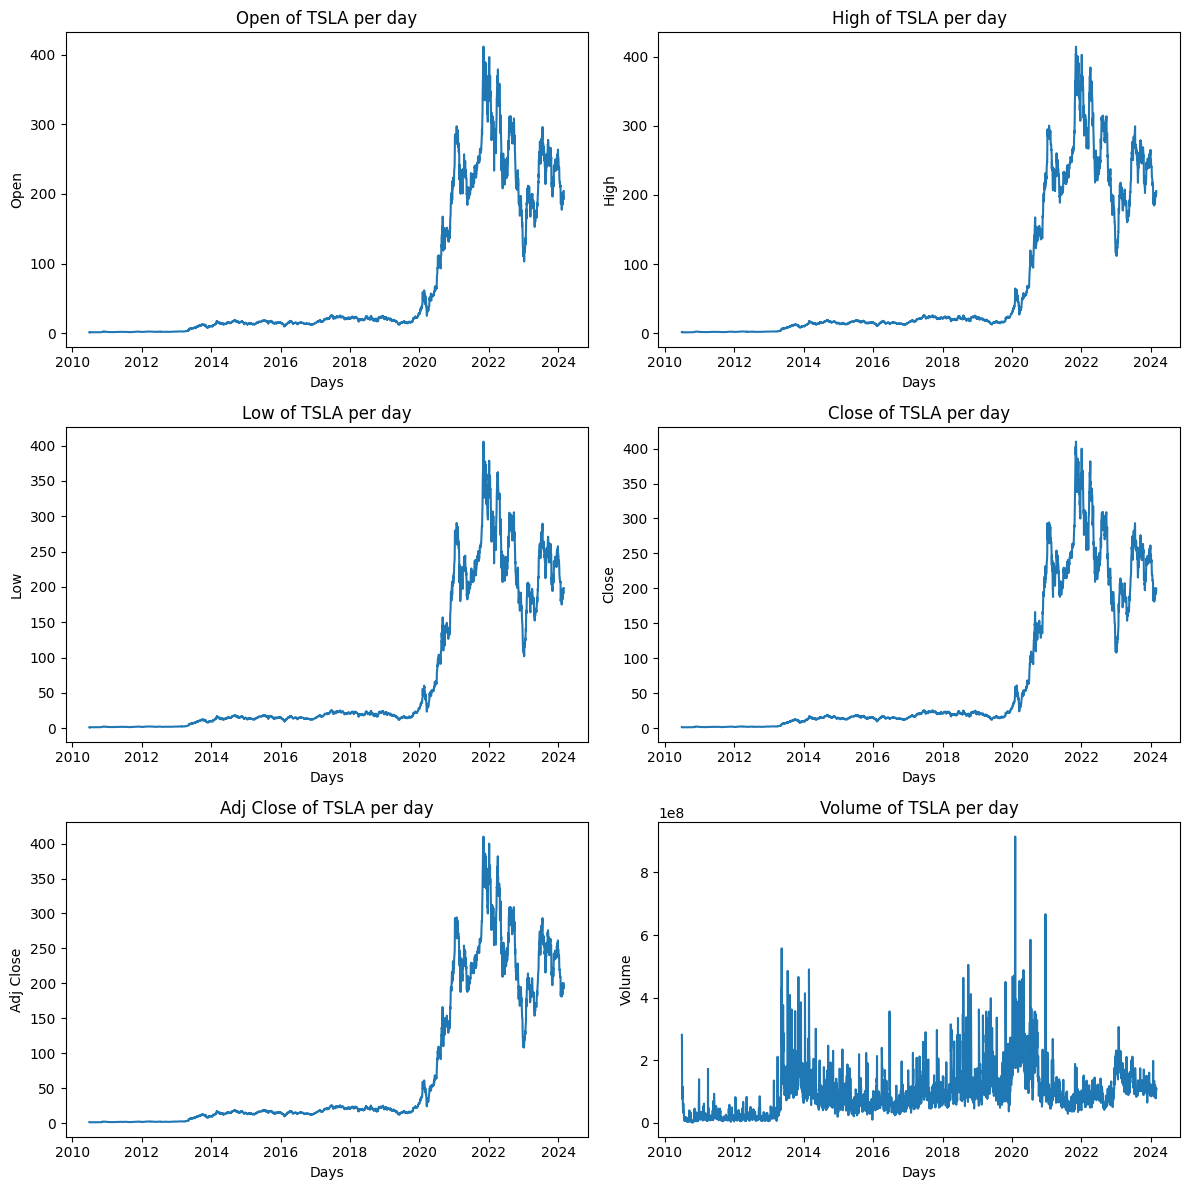

In [18]:
# Line plots for GOOG
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (12, 12))
row_col = [(0, 0), (0, 1),
           (1, 0), (1, 1),
           (2, 0), (2, 1)
          ]

for i, col_name in enumerate(df.loc[:, :'Volume'].columns):
    row, col = row_col[i]
    ax = axes[row, col]
    
    sns.lineplot(data = df, x = df.index, y = df[col_name], ax = ax)
    ax.set_title(f'{col_name} of TSLA per day')
    ax.set_xlabel('Days')
    ax.set_ylabel(col_name)

# fig.delaxes(axes[1, 1])
plt.tight_layout()
plt.show()

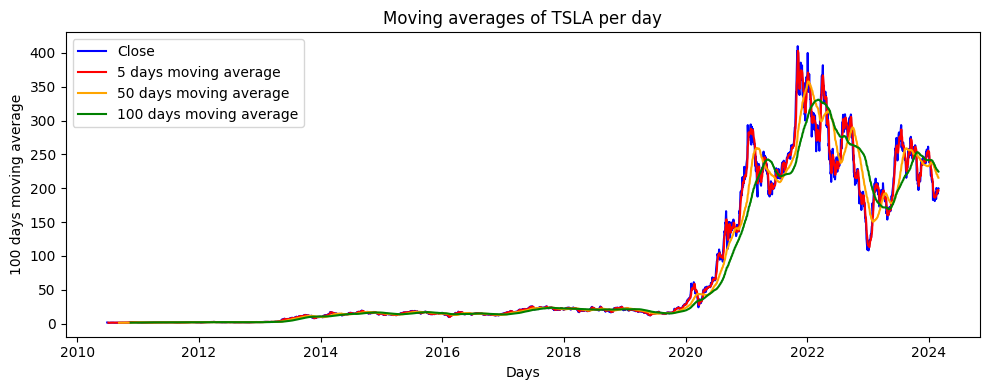

In [19]:
# Moving Averages Plot
plt.figure(figsize = (10, 4))
col_ma = ['Close', '5 days moving average', '50 days moving average', '100 days moving average']
line_colour = ['blue', 'red', 'orange', 'green']

for i, col_name in enumerate(col_ma):
    sns.lineplot(data = df, x = df.index, y = df[col_name], color = line_colour[i], label = col_name)
    
plt.title(f'Moving averages of TSLA per day')
plt.xlabel('Days')
plt.ylabel(col_name)
plt.legend()
plt.tight_layout()
plt.show()

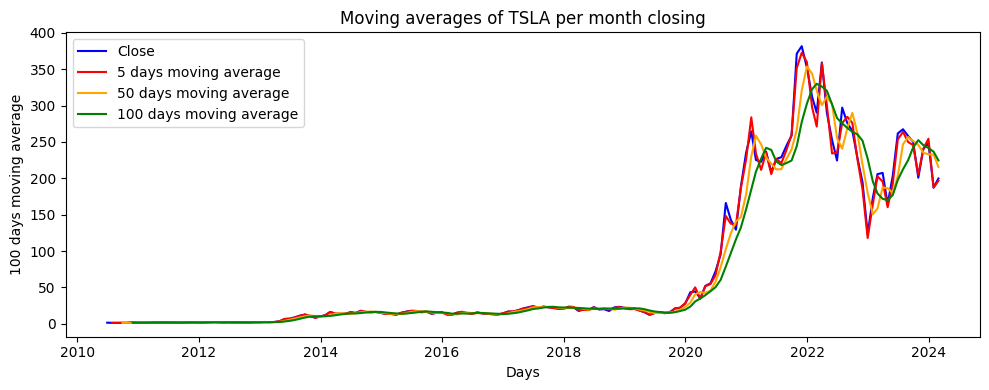

In [20]:
# Moving Averages Plot
plt.figure(figsize = (10, 4))
col_ma = ['Close', '5 days moving average', '50 days moving average', '100 days moving average']
line_colour = ['blue', 'red', 'orange', 'green']

for i, col_name in enumerate(col_ma):
    sns.lineplot(data = df_month, x = df_month.index, y = df_month[col_name], color = line_colour[i], label = col_name)
    
plt.title(f'Moving averages of TSLA per month closing')
plt.xlabel('Days')
plt.ylabel(col_name)
plt.legend()
plt.tight_layout()
plt.show()

As to be expected, moving average across a higher number of days will return a smoother graph but does not capture the small fluctuations in stock price.

<span style="font-size:24px; font-weight:bold; text-decoration:underline;">Data Preparation</span>

Now that we have fully explored the data and its correlations, we can start preparing the data and define some functions for model development.

The data is normalized using MinMaxScaler to preserve the shape and patterns of the distribution:

In [21]:
df.head(10)

,Open,High,Low,Close,Adj Close,Volume,5 days moving average,50 days moving average,100 days moving average
Date,,,,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500,NaN,NaN,NaN
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500,NaN,NaN,NaN
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000,NaN,NaN,NaN
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000,NaN,NaN,NaN
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500,1.399867,NaN,NaN
2010-07-07,1.093333,1.108667,0.998667,1.053333,1.053333,103825500,1.292000,NaN,NaN
2010-07-08,1.076000,1.168000,1.038000,1.164000,1.164000,115671000,1.207067,NaN,NaN
2010-07-09,1.172000,1.193333,1.103333,1.160000,1.160000,60759000,1.146267,NaN,NaN
2010-07-12,1.196667,1.204667,1.133333,1.136667,1.136667,33037500,1.117600,NaN,NaN


In [22]:
train_pct = 0.8
window_size = 60

# Get train length
close_data_df = df.iloc[4:, :7]
# close_data_df = df.filter(['Close'])
close_data = close_data_df.values
train_len = int(len(close_data) * train_pct)

# Sequence and labels
X_train = []
y_train = []
X_val = []
y_val = []
train_data = close_data[:train_len]
val_data = close_data[train_len - window_size:]

# Normalization
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
val_data = scaler.transform(val_data)

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i - window_size: i])
    y_train.append(train_data[i])
    
for i in range(window_size, len(val_data)):
    X_val.append(val_data[i - window_size: i])
    y_val.append(val_data[i])
    
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(2688, 60, 7)
(2688, 7)
(687, 60, 7)
(687, 7)


<span style="font-size:18px; font-weight:bold;">Functions:</span>

In [23]:
# Function to evaluate model
# prediction = model.predict(scaled_X_test)
# To define as (model_name)_lst if used in conjunction with error_compare_regression function
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

def model_evaluation(prediction):
    mae = mean_absolute_error(y_test, prediction)
    mape = mean_absolute_percentage_error(y_test, prediction)
    rmse = np.sqrt(mean_squared_error(y_test, prediction))
    r2 = r2_score(y_test, prediction)
    
    print(f'MAE: {mae}\nMAPE: {mape}\nRMSE: {rmse}\nR^2: {r2}')
    
    return [mae, mape, rmse, r2]

In [24]:
# Function to create comparison DF of MAE, MA%E, RMSE and R^2 for different models
# model_lst = list of model names ['lr', 'pr', 'grid_svr', 'grid_rfr']
# All (model_lst)_lst variables from 'model_evaluation' function must be defined
def error_compare_regression(model_lst):
    columns = ['MAE (lower better)', 'MAPE (lower better)', 'RMSE (lower better)', 'R^2 (closer to 1 better)']
    data_dict = {}
    
    for i in model_lst:
        data_dict[i+'_lst'] = globals()[i+'_lst']
    
    final_lst = [data_dict[i+'_lst'] for i in model_lst]
    return pd.DataFrame(data = final_lst, index = model_lst, columns = columns)

In [25]:
def r2_metric(y_true, y_pred):
    y_true_np = tf.reshape(y_true, [-1])
    y_pred_np = tf.reshape(y_pred, [-1])

    r2 = tf.py_function(r2_score, [y_true_np, y_pred_np], Tout=tf.float64)
    return r2

In [26]:
def min_val_metrics():
    min_val_mae = min(history.history['val_mae'])
    min_val_mse = min(history.history['val_mse'])
    max_val_r2 = max(history.history['val_r2_metric'])
    print(f'Min MAE on validation set: {min_val_mae:.4f}')
    print(f'Min MSE on validation set: {min_val_mse:.4f}')
    print(f'Min RMSE on validation set: {np.sqrt(min_val_mse):.4f}')
    print(f'Max R2 on validation set: {max_val_r2:.4f}')

<span style="font-size:24px; font-weight:bold; text-decoration:underline;">Model Development</span>

We will develop the model using the processed data. Multiple models will be tested while tuning the parameters.

All the stock price features along with the 5 day moving average will be fed into the model in attempt to capture the minor stock price changes.

<span style="font-size:18px; font-weight:bold;">Model 1 (LSTM):</span>

In [27]:
# Build the LSTM model
model_lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(150, return_sequences = True, input_shape= (X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(X_train.shape[2])
])

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 150)           94800     
                                                                 
 dropout (Dropout)           (None, 60, 150)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               100400    
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 7)                 182       
                                                                 
Total params: 197,907
Trainable params: 197,907
Non-trai

In [28]:
model_lstm.compile(loss = 'mse', optimizer = Adam(learning_rate = 0.01), metrics = ['mse', 'mae', r2_metric])

In [29]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_mse',
                                            patience = 3,
                                            verbose = 1,
                                            factor = 0.5,
                                            min_lr = 0.0000001)

In [30]:
batch_size = 64
train_data = len(X_train)
val_data = len(X_val)
steps_per_epoch = train_data // batch_size
validation_steps = val_data // batch_size

history = model_lstm.fit(
    X_train,
    y_train,
    batch_size = batch_size,
    epochs = 100,
    steps_per_epoch = steps_per_epoch,
    verbose = 1,
    validation_data = (X_val, y_val),
    validation_steps = validation_steps,
    callbacks = [learning_rate_reduction]
)

Epoch 1/100
42/42 [==============================] - 6s 35ms/step - loss: 0.0141 - mse: 0.0141 - mae: 0.0538 - r2_metric: 0.5752 - val_loss: 0.1071 - val_mse: 0.1071 - val_mae: 0.1666 - val_r2_metric: 0.0063 - lr: 0.0100
Epoch 2/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0249 - r2_metric: 0.9243 - val_loss: 0.1136 - val_mse: 0.1136 - val_mae: 0.1840 - val_r2_metric: -0.0666 - lr: 0.0100
Epoch 3/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0182 - r2_metric: 0.9495 - val_loss: 0.0605 - val_mse: 0.0605 - val_mae: 0.1277 - val_r2_metric: 0.4822 - lr: 0.0100
Epoch 4/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0181 - r2_metric: 0.9501 - val_loss: 0.0403 - val_mse: 0.0403 - val_mae: 0.1150 - val_r2_metric: 0.6324 - lr: 0.0100
Epoch 5/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0224 - r2_m

Epoch 32/100
42/42 [==============================] - 1s 18ms/step - loss: 6.9447e-04 - mse: 6.9447e-04 - mae: 0.0118 - r2_metric: 0.9691 - val_loss: 0.0018 - val_mse: 0.0018 - val_mae: 0.0305 - val_r2_metric: 0.9797 - lr: 1.5625e-04
Epoch 33/100
42/42 [==============================] - 1s 17ms/step - loss: 7.0307e-04 - mse: 7.0307e-04 - mae: 0.0118 - r2_metric: 0.9724 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0295 - val_r2_metric: 0.9808 - lr: 1.5625e-04
Epoch 34/100
39/42 [==========================>...] - ETA: 0s - loss: 6.7308e-04 - mse: 6.7308e-04 - mae: 0.0117 - r2_metric: 0.9745
Epoch 34: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.
42/42 [==============================] - 1s 18ms/step - loss: 6.7667e-04 - mse: 6.7667e-04 - mae: 0.0117 - r2_metric: 0.9735 - val_loss: 0.0015 - val_mse: 0.0015 - val_mae: 0.0272 - val_r2_metric: 0.9828 - lr: 1.5625e-04
Epoch 35/100
42/42 [==============================] - 1s 18ms/step - loss: 6.8579e-04 - mse: 6.8579e-

42/42 [==============================] - 1s 17ms/step - loss: 6.8571e-04 - mse: 6.8571e-04 - mae: 0.0118 - r2_metric: 0.9705 - val_loss: 0.0015 - val_mse: 0.0015 - val_mae: 0.0276 - val_r2_metric: 0.9826 - lr: 1.0000e-07
Epoch 93/100
42/42 [==============================] - 1s 17ms/step - loss: 6.9311e-04 - mse: 6.9311e-04 - mae: 0.0118 - r2_metric: 0.9716 - val_loss: 0.0015 - val_mse: 0.0015 - val_mae: 0.0276 - val_r2_metric: 0.9826 - lr: 1.0000e-07
Epoch 94/100
42/42 [==============================] - 1s 17ms/step - loss: 6.8542e-04 - mse: 6.8542e-04 - mae: 0.0117 - r2_metric: 0.9731 - val_loss: 0.0015 - val_mse: 0.0015 - val_mae: 0.0276 - val_r2_metric: 0.9826 - lr: 1.0000e-07
Epoch 95/100
42/42 [==============================] - 1s 17ms/step - loss: 7.0327e-04 - mse: 7.0327e-04 - mae: 0.0118 - r2_metric: 0.9717 - val_loss: 0.0015 - val_mse: 0.0015 - val_mae: 0.0276 - val_r2_metric: 0.9826 - lr: 1.0000e-07
Epoch 96/100
42/42 [==============================] - 1s 17ms/step - loss: 6.

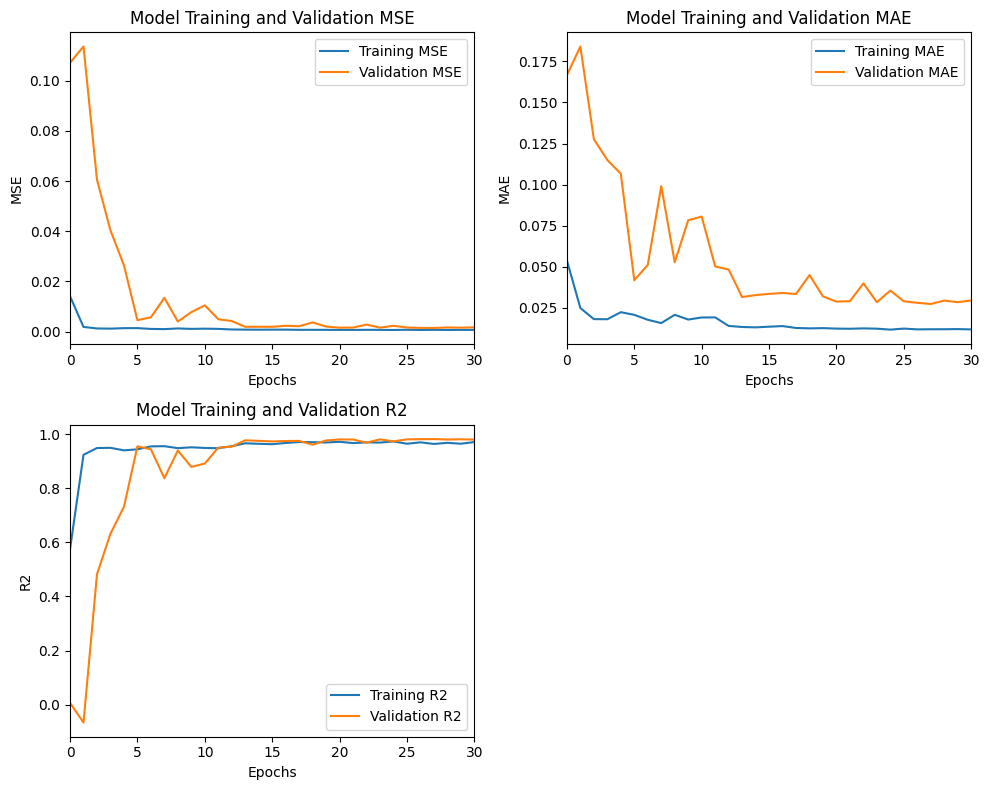

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

titles = ['MSE', 'MAE', 'R2']
metrics = ['mse', 'mae', 'r2_metric']
labels = ['Training', 'Validation']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[i // 2, i % 2]
#     ax = axes[i]
    ax.plot(history.history[metric], label = f'{labels[0]} {title}')
    ax.plot(history.history[f'val_{metric}'], label = f'{labels[1]} {title}')
    ax.set_title(f'Model Training and Validation {title}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(title)
    ax.set_xlim(0, 30)
#     ax.set_xticks(np.arange(0, 19, step = 1))
    ax.legend()

fig.delaxes(axes[1, 1])
plt.tight_layout()
plt.show()

In [32]:
min_val_metrics()

Min MAE on validation set: 0.0272
Min MSE on validation set: 0.0015
Min RMSE on validation set: 0.0383
Max R2 on validation set: 0.9828


In [33]:
# Get the models predicted closing price
predictions = model_lstm.predict(X_val)
predictions_inversed = scaler.inverse_transform(predictions)

22/22 [==============================] - 1s 19ms/step


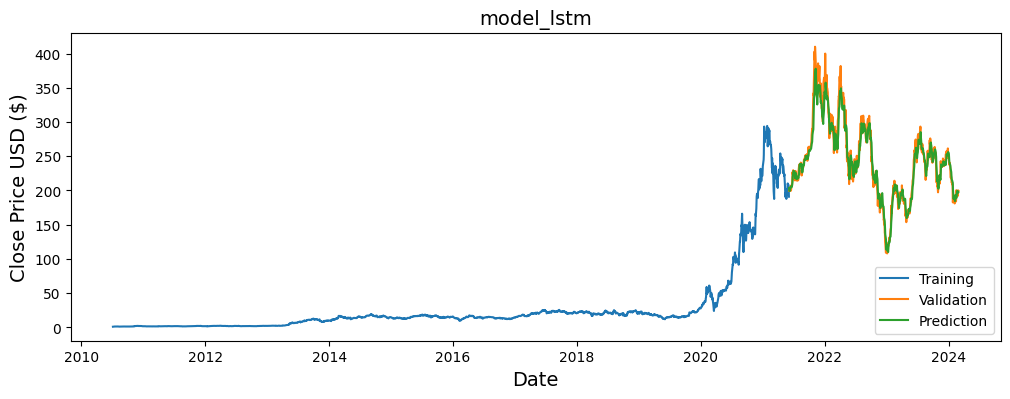

In [34]:
train = close_data_df[:train_len]
valid = close_data_df[train_len:]
valid[['Open_pred', 'High_pred', 'Low_pred', 'Close_pred',
       'Adj Close_pred', 'Volume_pred', '5 days moving average_pred']] = predictions_inversed

# Visualize the data
plt.figure(figsize = (12, 4))
plt.title('model_lstm', fontsize = 14)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Close Price USD ($)', fontsize = 14)
plt.plot(train.index, train['Close'])
plt.plot(valid.index, valid[['Close', 'Close_pred']])
plt.legend(['Training', 'Validation', 'Prediction'], loc = 'lower right')
plt.show()

<span style="font-size:18px; font-weight:bold;">Model 2 (LSTM + GRU):</span>

In [35]:
tf.keras.backend.clear_session()

batch_size = 128
train_data = len(X_train)
val_data = len(X_val)
steps_per_epoch = train_data // batch_size
validation_steps = val_data // batch_size

# Build the LSTM model
model_lstm_gru = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(130, return_sequences = True, input_shape= (X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.GRU(65, activation = 'tanh'),
    tf.keras.layers.Dense(30),
    tf.keras.layers.Dense(X_train.shape[2])
])

model_lstm_gru.summary()

model_lstm_gru.compile(loss = 'mse', optimizer = Adam(learning_rate = 0.01), metrics = ['mse', 'mae', r2_metric])

history = model_lstm_gru.fit(
    X_train,
    y_train,
    batch_size = batch_size,
    epochs = 100,
    steps_per_epoch = steps_per_epoch,
    verbose = 1,
    validation_data = (X_val, y_val),
    validation_steps = validation_steps,
    callbacks = [learning_rate_reduction]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 130)           71760     
                                                                 
 gru (GRU)                   (None, 65)                38415     
                                                                 
 dense (Dense)               (None, 30)                1980      
                                                                 
 dense_1 (Dense)             (None, 7)                 217       
                                                                 
Total params: 112,372
Trainable params: 112,372
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
21/21 [==============================] - 3s 59ms/step - loss: 0.0176 - mse: 0.0176 - mae: 0.0658 - r2_metric: 0.4129 - val_loss: 0.0135 - val_mse: 0.0135 - val_mae: 0.086

Epoch 28/100
21/21 [==============================] - 0s 15ms/step - loss: 5.0924e-04 - mse: 5.0924e-04 - mae: 0.0078 - r2_metric: 0.9809 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0245 - val_r2_metric: 0.9857 - lr: 1.5625e-04
Epoch 29/100
21/21 [==============================] - 0s 15ms/step - loss: 5.0762e-04 - mse: 5.0762e-04 - mae: 0.0077 - r2_metric: 0.9812 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0247 - val_r2_metric: 0.9857 - lr: 1.5625e-04
Epoch 30/100
21/21 [==============================] - ETA: 0s - loss: 5.0757e-04 - mse: 5.0757e-04 - mae: 0.0077 - r2_metric: 0.9798
Epoch 30: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.
21/21 [==============================] - 0s 15ms/step - loss: 5.0757e-04 - mse: 5.0757e-04 - mae: 0.0077 - r2_metric: 0.9798 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0244 - val_r2_metric: 0.9861 - lr: 1.5625e-04
Epoch 31/100
21/21 [==============================] - 0s 15ms/step - loss: 5.0676e-04 - mse: 5.0676e-

21/21 [==============================] - 0s 16ms/step - loss: 5.0523e-04 - mse: 5.0523e-04 - mae: 0.0077 - r2_metric: 0.9817 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0244 - val_r2_metric: 0.9860 - lr: 1.0000e-07
Epoch 89/100
21/21 [==============================] - 0s 15ms/step - loss: 5.0523e-04 - mse: 5.0523e-04 - mae: 0.0077 - r2_metric: 0.9802 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0244 - val_r2_metric: 0.9860 - lr: 1.0000e-07
Epoch 90/100
21/21 [==============================] - 0s 15ms/step - loss: 5.0524e-04 - mse: 5.0524e-04 - mae: 0.0077 - r2_metric: 0.9798 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0244 - val_r2_metric: 0.9860 - lr: 1.0000e-07
Epoch 91/100
21/21 [==============================] - 0s 15ms/step - loss: 5.0524e-04 - mse: 5.0524e-04 - mae: 0.0077 - r2_metric: 0.9819 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0244 - val_r2_metric: 0.9860 - lr: 1.0000e-07
Epoch 92/100
21/21 [==============================] - 0s 15ms/step - loss: 5.

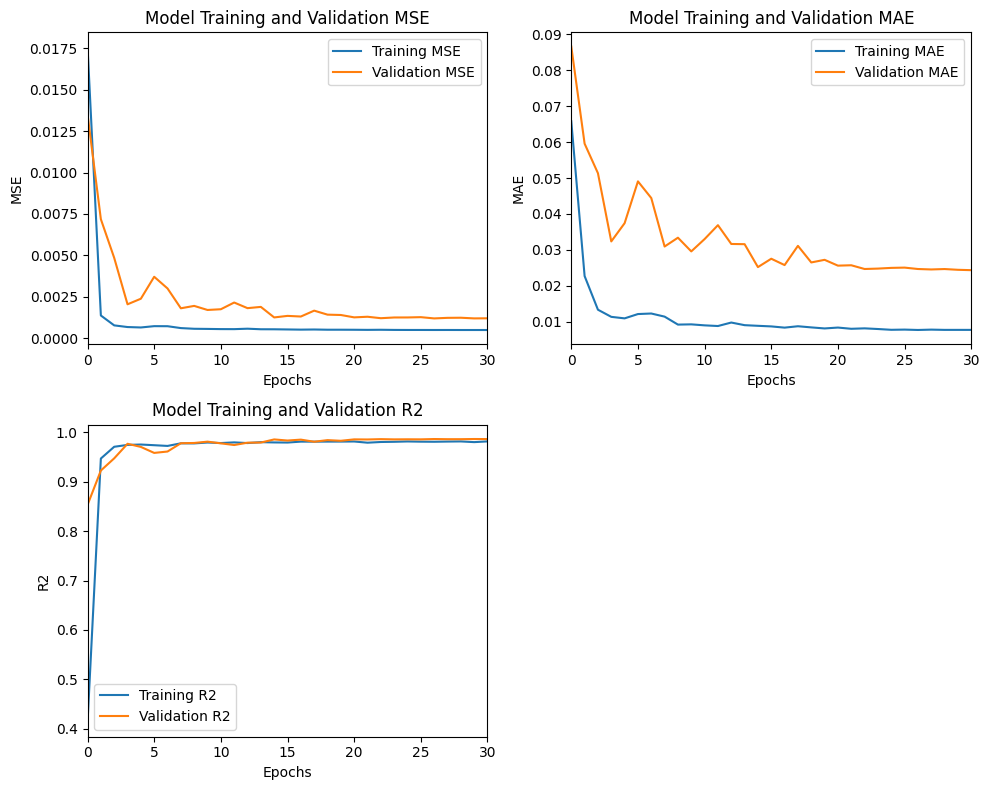

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

titles = ['MSE', 'MAE', 'R2']
metrics = ['mse', 'mae', 'r2_metric']
labels = ['Training', 'Validation']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[i // 2, i % 2]
#     ax = axes[i]
    ax.plot(history.history[metric], label = f'{labels[0]} {title}')
    ax.plot(history.history[f'val_{metric}'], label = f'{labels[1]} {title}')
    ax.set_title(f'Model Training and Validation {title}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(title)
    ax.set_xlim(0, 30)
#     ax.set_xticks(np.arange(0, 19, step = 1))
    ax.legend()

fig.delaxes(axes[1, 1])
plt.tight_layout()
plt.show()

In [37]:
min_val_metrics()

Min MAE on validation set: 0.0243
Min MSE on validation set: 0.0012
Min RMSE on validation set: 0.0347
Max R2 on validation set: 0.9861


22/22 [==============================] - 1s 4ms/step


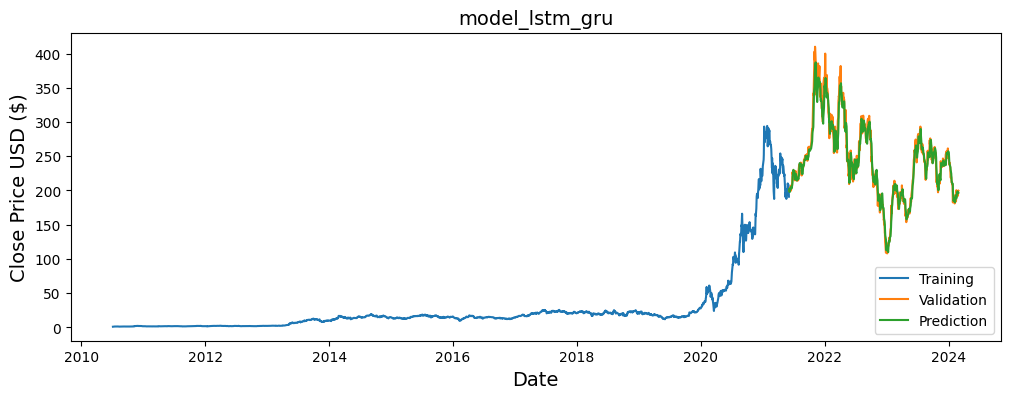

In [38]:
# Get the models predicted closing price
predictions = model_lstm_gru.predict(X_val)
predictions_inversed = scaler.inverse_transform(predictions)

train = close_data_df[:train_len]
valid = close_data_df[train_len:]
valid[['Open_pred', 'High_pred', 'Low_pred', 'Close_pred',
       'Adj Close_pred', 'Volume_pred', '5 days moving average_pred']] = predictions_inversed

# Visualize the data
plt.figure(figsize = (12, 4))
plt.title('model_lstm_gru', fontsize = 14)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Close Price USD ($)', fontsize = 14)
plt.plot(train.index, train['Close'])
plt.plot(valid.index, valid[['Close', 'Close_pred']])
plt.legend(['Training', 'Validation', 'Prediction'], loc = 'lower right')
plt.show()

<span style="font-size:18px; font-weight:bold;">Model 3 (GRU):</span>

In [39]:
tf.keras.backend.clear_session()

batch_size = 128
train_data = len(X_train)
val_data = len(X_val)
steps_per_epoch = train_data // batch_size
validation_steps = val_data // batch_size

# Build the LSTM model
model_gru = tf.keras.models.Sequential([
    tf.keras.layers.GRU(128, activation = 'tanh', input_shape= (X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dense(X_train.shape[2])
])

model_gru.summary()

model_gru.compile(loss = 'mse', optimizer = Adam(learning_rate = 0.01), metrics = ['mse', 'mae', r2_metric])

history = model_gru.fit(
    X_train,
    y_train,
    batch_size = batch_size,
    epochs = 50,
    steps_per_epoch = steps_per_epoch,
    verbose = 1,
    validation_data = (X_val, y_val),
    validation_steps = validation_steps,
    callbacks = [learning_rate_reduction]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               52608     
                                                                 
 dense (Dense)               (None, 7)                 903       
                                                                 
Total params: 53,511
Trainable params: 53,511
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
21/21 [==============================] - 2s 37ms/step - loss: 0.0072 - mse: 0.0072 - mae: 0.0464 - r2_metric: 0.7598 - val_loss: 0.0128 - val_mse: 0.0128 - val_mae: 0.0798 - val_r2_metric: 0.8421 - lr: 0.0100
Epoch 2/50
21/21 [==============================] - 0s 18ms/step - loss: 8.7841e-04 - mse: 8.7841e-04 - mae: 0.0149 - r2_metric: 0.9669 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0277 - val_r2_metric: 0.9828 - lr: 0.0100


Epoch 28/50
21/21 [==============================] - 0s 11ms/step - loss: 4.6986e-04 - mse: 4.6986e-04 - mae: 0.0068 - r2_metric: 0.9824 - val_loss: 7.1177e-04 - val_mse: 7.1177e-04 - val_mae: 0.0186 - val_r2_metric: 0.9912 - lr: 1.5625e-04
Epoch 29/50
21/21 [==============================] - 0s 11ms/step - loss: 4.6910e-04 - mse: 4.6910e-04 - mae: 0.0067 - r2_metric: 0.9826 - val_loss: 7.0774e-04 - val_mse: 7.0774e-04 - val_mae: 0.0185 - val_r2_metric: 0.9912 - lr: 1.5625e-04
Epoch 30/50
19/21 [==========================>...] - ETA: 0s - loss: 4.6543e-04 - mse: 4.6543e-04 - mae: 0.0067 - r2_metric: 0.9812
Epoch 30: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.
21/21 [==============================] - 0s 11ms/step - loss: 4.6941e-04 - mse: 4.6941e-04 - mae: 0.0067 - r2_metric: 0.9814 - val_loss: 6.9602e-04 - val_mse: 6.9602e-04 - val_mae: 0.0184 - val_r2_metric: 0.9913 - lr: 1.5625e-04
Epoch 31/50
21/21 [==============================] - 0s 11ms/step - loss: 4.6929

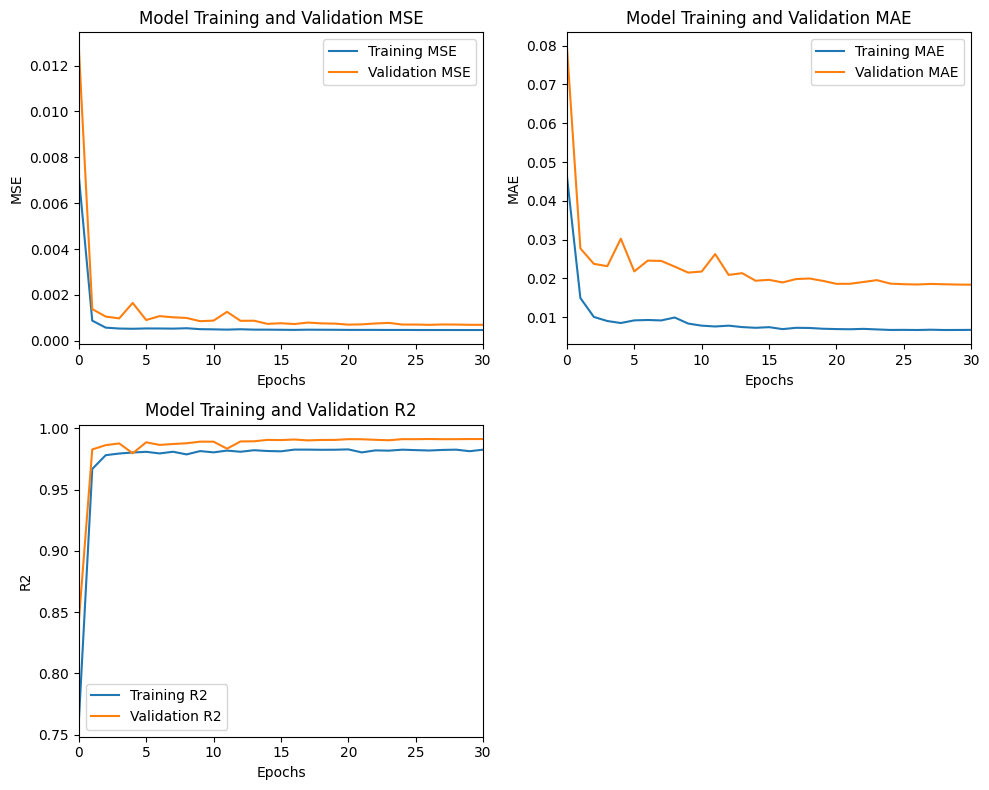

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

titles = ['MSE', 'MAE', 'R2']
metrics = ['mse', 'mae', 'r2_metric']
labels = ['Training', 'Validation']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[i // 2, i % 2]
#     ax = axes[i]
    ax.plot(history.history[metric], label = f'{labels[0]} {title}')
    ax.plot(history.history[f'val_{metric}'], label = f'{labels[1]} {title}')
    ax.set_title(f'Model Training and Validation {title}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(title)
    ax.set_xlim(0, 30)
#     ax.set_xticks(np.arange(0, 19, step = 1))
    ax.legend()

fig.delaxes(axes[1, 1])
plt.tight_layout()
plt.show()

In [41]:
min_val_metrics()

Min MAE on validation set: 0.0184
Min MSE on validation set: 0.0007
Min RMSE on validation set: 0.0264
Max R2 on validation set: 0.9913


22/22 [==============================] - 0s 3ms/step


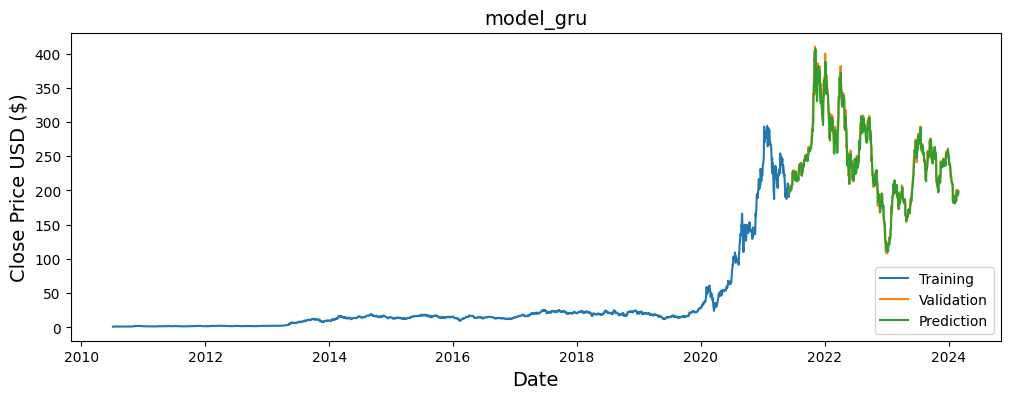

In [42]:
# Get the models predicted closing price
predictions = model_gru.predict(X_val)
predictions_inversed = scaler.inverse_transform(predictions)

train = close_data_df[:train_len]
valid = close_data_df[train_len:]
valid[['Open_pred', 'High_pred', 'Low_pred', 'Close_pred',
       'Adj Close_pred', 'Volume_pred', '5 days moving average_pred']] = predictions_inversed

# Visualize the data
plt.figure(figsize = (12, 4))
plt.title('model_gru', fontsize = 14)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Close Price USD ($)', fontsize = 14)
plt.plot(train.index, train['Close'])
plt.plot(valid.index, valid[['Close', 'Close_pred']])
plt.legend(['Training', 'Validation', 'Prediction'], loc = 'lower right')
plt.show()

<span style="font-size:18px; font-weight:bold;">Model 4 (LSTM + Droupout):</span>

In [43]:
tf.keras.backend.clear_session()

batch_size = 128
train_data = len(X_train)
val_data = len(X_val)
steps_per_epoch = train_data // batch_size
validation_steps = val_data // batch_size

# Build the bilstm model
model_bilstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, return_sequences = True, input_shape= (X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, return_sequences = False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(X_train.shape[2])
])

model_bilstm.summary()

model_bilstm.compile(loss = 'mse', optimizer = Adam(learning_rate = 0.01), metrics = ['mse', 'mae', r2_metric])

history = model_bilstm.fit(
    X_train,
    y_train,
    batch_size = batch_size,
    epochs = 200,
    steps_per_epoch = steps_per_epoch,
    verbose = 1,
    validation_data = (X_val, y_val),
    validation_steps = validation_steps,
    callbacks = [learning_rate_reduction]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            11600     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 7)                 3

Epoch 57/200
21/21 [==============================] - 0s 17ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0147 - r2_metric: 0.9586 - val_loss: 0.0036 - val_mse: 0.0036 - val_mae: 0.0398 - val_r2_metric: 0.9639 - lr: 2.4414e-06
Epoch 58/200
21/21 [==============================] - 0s 17ms/step - loss: 9.6985e-04 - mse: 9.6985e-04 - mae: 0.0144 - r2_metric: 0.9647 - val_loss: 0.0036 - val_mse: 0.0036 - val_mae: 0.0399 - val_r2_metric: 0.9638 - lr: 2.4414e-06
Epoch 59/200
21/21 [==============================] - ETA: 0s - loss: 0.0010 - mse: 0.0010 - mae: 0.0147 - r2_metric: 0.9622        
Epoch 59: ReduceLROnPlateau reducing learning rate to 1.220703097715159e-06.
21/21 [==============================] - 0s 17ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0147 - r2_metric: 0.9622 - val_loss: 0.0036 - val_mse: 0.0036 - val_mae: 0.0399 - val_r2_metric: 0.9637 - lr: 2.4414e-06
Epoch 60/200
21/21 [==============================] - 0s 17ms/step - loss: 9.5435e-04 - mse: 9.5435e-04 - mae: 0.0143

21/21 [==============================] - 0s 18ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0147 - r2_metric: 0.9616 - val_loss: 0.0036 - val_mse: 0.0036 - val_mae: 0.0398 - val_r2_metric: 0.9640 - lr: 1.0000e-07
Epoch 124/200
21/21 [==============================] - 0s 17ms/step - loss: 9.8717e-04 - mse: 9.8717e-04 - mae: 0.0144 - r2_metric: 0.9633 - val_loss: 0.0036 - val_mse: 0.0036 - val_mae: 0.0398 - val_r2_metric: 0.9640 - lr: 1.0000e-07
Epoch 125/200
21/21 [==============================] - 0s 17ms/step - loss: 9.5706e-04 - mse: 9.5706e-04 - mae: 0.0143 - r2_metric: 0.9640 - val_loss: 0.0035 - val_mse: 0.0035 - val_mae: 0.0397 - val_r2_metric: 0.9640 - lr: 1.0000e-07
Epoch 126/200
21/21 [==============================] - 0s 17ms/step - loss: 9.5208e-04 - mse: 9.5208e-04 - mae: 0.0144 - r2_metric: 0.9651 - val_loss: 0.0035 - val_mse: 0.0035 - val_mae: 0.0397 - val_r2_metric: 0.9640 - lr: 1.0000e-07
Epoch 127/200
21/21 [==============================] - 0s 17ms/step - loss: 0.0010

21/21 [==============================] - 0s 18ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0145 - r2_metric: 0.9624 - val_loss: 0.0035 - val_mse: 0.0035 - val_mae: 0.0397 - val_r2_metric: 0.9641 - lr: 1.0000e-07
Epoch 194/200
21/21 [==============================] - 0s 17ms/step - loss: 9.6507e-04 - mse: 9.6507e-04 - mae: 0.0144 - r2_metric: 0.9635 - val_loss: 0.0035 - val_mse: 0.0035 - val_mae: 0.0397 - val_r2_metric: 0.9641 - lr: 1.0000e-07
Epoch 195/200
21/21 [==============================] - 0s 17ms/step - loss: 9.9045e-04 - mse: 9.9045e-04 - mae: 0.0146 - r2_metric: 0.9629 - val_loss: 0.0035 - val_mse: 0.0035 - val_mae: 0.0397 - val_r2_metric: 0.9641 - lr: 1.0000e-07
Epoch 196/200
21/21 [==============================] - 0s 17ms/step - loss: 9.7753e-04 - mse: 9.7753e-04 - mae: 0.0143 - r2_metric: 0.9636 - val_loss: 0.0035 - val_mse: 0.0035 - val_mae: 0.0397 - val_r2_metric: 0.9641 - lr: 1.0000e-07
Epoch 197/200
21/21 [==============================] - 0s 17ms/step - loss: 9.7229

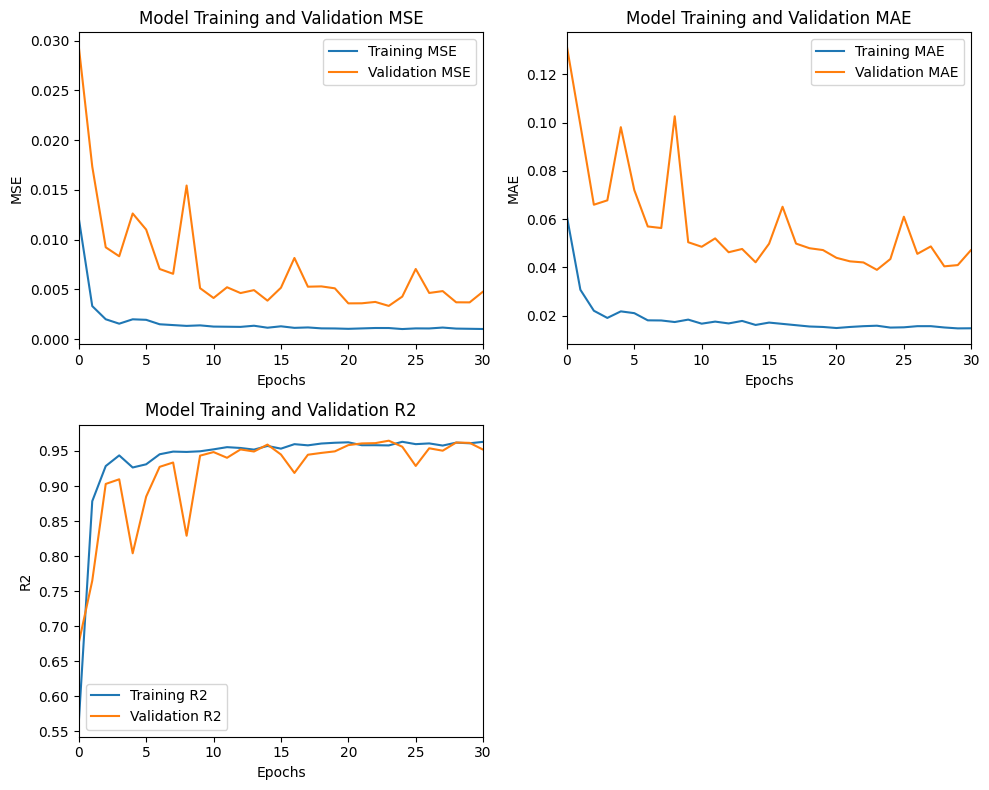

In [44]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

titles = ['MSE', 'MAE', 'R2']
metrics = ['mse', 'mae', 'r2_metric']
labels = ['Training', 'Validation']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[i // 2, i % 2]
#     ax = axes[i]
    ax.plot(history.history[metric], label = f'{labels[0]} {title}')
    ax.plot(history.history[f'val_{metric}'], label = f'{labels[1]} {title}')
    ax.set_title(f'Model Training and Validation {title}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(title)
    ax.set_xlim(0, 30)
#     ax.set_xticks(np.arange(0, 19, step = 1))
    ax.legend()

fig.delaxes(axes[1, 1])
plt.tight_layout()
plt.show()

In [45]:
min_val_metrics()

Min MAE on validation set: 0.0389
Min MSE on validation set: 0.0031
Min RMSE on validation set: 0.0561
Max R2 on validation set: 0.9657


22/22 [==============================] - 1s 12ms/step


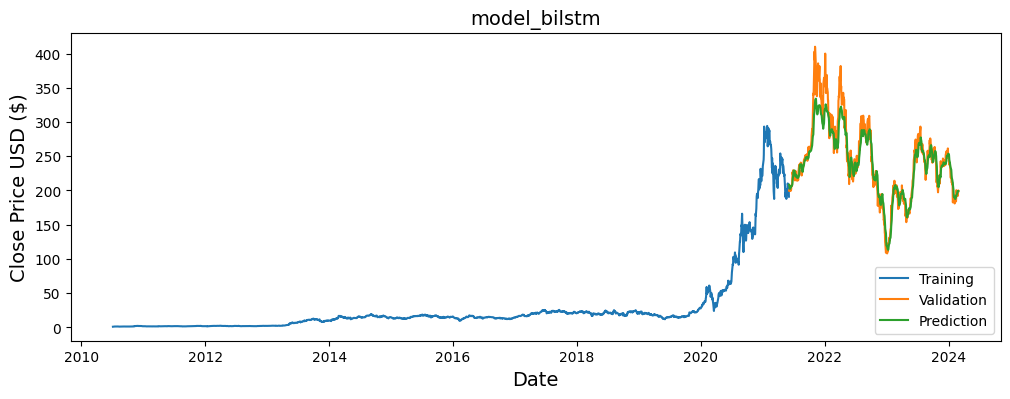

In [46]:
# Get the models predicted closing price
predictions = model_bilstm.predict(X_val)
predictions_inversed = scaler.inverse_transform(predictions)

train = close_data_df[:train_len]
valid = close_data_df[train_len:]
valid[['Open_pred', 'High_pred', 'Low_pred', 'Close_pred',
       'Adj Close_pred', 'Volume_pred', '5 days moving average_pred']] = predictions_inversed

# Visualize the data
plt.figure(figsize = (12, 4))
plt.title('model_bilstm', fontsize = 14)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Close Price USD ($)', fontsize = 14)
plt.plot(train.index, train['Close'])
plt.plot(valid.index, valid[['Close', 'Close_pred']])
plt.legend(['Training', 'Validation', 'Prediction'], loc = 'lower right')
plt.show()

<span style="font-size:18px; font-weight:bold;">Best Model Training:</span>

The simple GRU model 3 seems to have the best MAE, MSE and RMSE on the validation set and the higher R2 score of 99% indicates that the model is able to explain 99% of the variability in the target using the features fed, meaning it is not blindly guessing a prediction value.

Although the model prediction on the validation data shown in the graph of closing price prediction seem promising, this could be due to data leakage as the model has already been trained on the validation set during the training phase to obtain the validation metrics. Besides that, there seems to be overfitting based on the training vs validation metrics.

We will train the final model using the architecture of GRU model 3 on the full dataset:

In [47]:
window_size = 60
X_all = []
y_all = []
scaled_close_data = close_data
scaled_close_data = scaler.transform(scaled_close_data)

for i in range(window_size, len(scaled_close_data)):
    X_all.append(scaled_close_data[i - window_size: i])
    y_all.append(scaled_close_data[i])

X_all = np.array(X_all)
y_all = np.array(y_all)
print(X_all.shape)
print(y_all.shape)

(3375, 60, 7)
(3375, 7)


In [48]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'mse',
                                            patience = 3,
                                            verbose = 1,
                                            factor = 0.5,
                                            min_lr = 0.0000001)

In [49]:
tf.keras.backend.clear_session()

batch_size = 128

# Build the bilstm model
model_gru_final = tf.keras.models.Sequential([
    tf.keras.layers.GRU(128, activation = 'tanh', input_shape= (X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dense(X_train.shape[2])
])

model_gru_final.summary()

model_gru_final.compile(loss = 'mse', optimizer = Adam(learning_rate = 0.01), metrics = ['mse', 'mae', r2_metric])

history = model_gru_final.fit(
    X_all,
    y_all,
    batch_size = batch_size,
    epochs = 50,
    steps_per_epoch = steps_per_epoch,
    verbose = 1,
    callbacks = [learning_rate_reduction]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               52608     
                                                                 
 dense (Dense)               (None, 7)                 903       
                                                                 
Total params: 53,511
Trainable params: 53,511
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
21/21 [==============================] - 2s 25ms/step - loss: 0.0152 - mse: 0.0152 - mae: 0.0588 - r2_metric: 0.8741 - lr: 0.0100
Epoch 2/50
21/21 [==============================] - 0s 14ms/step - loss: 9.0813e-04 - mse: 9.0813e-04 - mae: 0.0171 - r2_metric: 0.9912 - lr: 0.0100
Epoch 3/50
21/21 [==============================] - 0s 9ms/step - loss: 7.1747e-04 - mse: 7.1747e-04 - mae: 0.0135 - r2_metric: 0.9932 - lr: 0.0100
Epoch 4/50

<span style="font-size:24px; font-weight:bold; text-decoration:underline;">Prediction</span>

We will attempt to predict the future stock price using this model:

In [50]:
# Function to predict future stock prices for weekdays
def predict_future_prices_update_df(model, data_df, num_predictions, window_size, input_amt = 252):
    prediction_date = []
    predicted_prices = []
    close_data_df_copy = data_df.copy()

    for i in range(num_predictions):
        next_date = close_data_df_copy.index[-1] + pd.Timedelta(days = 1)

        while next_date.isoweekday() >= 6:
            next_date += pd.Timedelta(days = 1)
        
        prediction_date.append(next_date)
        
        # Extract last N days of stock prices
        scaled_close_data_df_copy = scaler.transform(close_data_df_copy)
        input_data_arr = []
        
        for i in range(input_amt, 0, -1): # Default: 252 - 0
            input_data_arr.append(scaled_close_data_df_copy[-window_size -i: -i])
            
        input_data_arr = np.array(input_data_arr)
        
        # Predict next day stock price
        scaled_prediction = model.predict(input_data_arr)
        predictions_inversed = scaler.inverse_transform(scaled_prediction)
        predictions_inversed = predictions_inversed[-1][3]
#         predictions_inversed = round(float(predictions_inversed), 2)
        
        # Extract last N days of stock prices
#         input_data = close_data_df_copy[-window_size:].values
#         scaled_input_data = scaler.transform(input_data)
#         scaled_input_data_expanded = np.expand_dims(scaled_input_data, axis = 0)

        # Predict next day stock price
#         scaled_prediction = model.predict(scaled_input_data_expanded)
#         predictions_inversed = scaler.inverse_transform(scaled_prediction)
#         predictions_inversed = round(float(predictions_inversed[0][0]), 2)

        # Update list and dataframe
        predicted_prices.append(predictions_inversed)
        close_data_df_copy.loc[next_date] = predictions_inversed

    # Dataframe for predictions
    predicted_df = pd.DataFrame(predicted_prices, index = prediction_date, columns = ['predicted_price'])

    return predicted_df

In [51]:
# Visualize the data
def visualize_prediction(ori_df, pred_df):
    plt.figure(figsize = (12, 6))
    plt.title('Prediction', fontsize = 14)
    plt.xlabel('Date', fontsize = 14)
    plt.ylabel('Close Price USD ($)', fontsize = 14)
    plt.plot(close_data_df.index, close_data_df['Close'])
    plt.plot(predicted_df.index, predicted_df['predicted_price'])
    plt.legend(['Existing', 'Prediction'], loc = 'lower right')
    plt.show()

In [52]:
num_predictions = 30
window_size = 60
input_amt = 252
predicted_df = predict_future_prices_update_df(model_gru_final, close_data_df, num_predictions, window_size, input_amt)

8/8 [==============================] - 0s 7ms/step


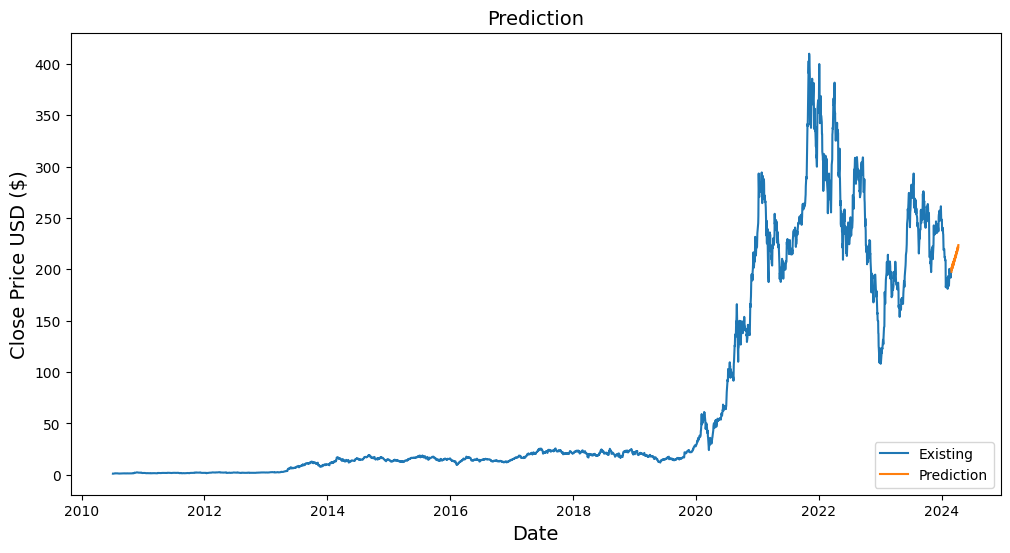

In [53]:
visualize_prediction(close_data_df, predicted_df)

From the 30 days future prediction of the model, it can be seen that the model predicts an almost linear increase in stock price for the next month.

When predicting the stock price for the next year, the model predicts the stock price to increase linearly and gradually stagnants upon reaching the all time high.

This shows that the model is merely predicting the trend of the stock prices following the current trend from the past few days. It follows the trend until it reaches the stock price peak as the data used for training has only been able to reach this value once across the past 10 years.

Moreover, the model is unable to predict the moment where the stock price drops. This is because changes in stock prices are mostly affected by external events that the model is not aware of. For example, a well timed news or rumour regarding a company could greatly affect the stock market where even professionals could not predict. Hence the linear increase in price predictions from the model.

<span style="font-size:24px; font-weight:bold; text-decoration:underline;">Conclusion</span>

1. Building a stock prediction neural network model is not as straight forward as it seems, if even possible. As machine learning models learn from historic patterns in order to predict a future value, it is unable to predict a future value accurately if a similar pattern has not occured or is of less frequency.

2. Stock prices are mostly affected by a large variety of external events which are unpredictable. Therefore, without any info on the exact date where these events happen, the model would not be able to predict an accurate price as stock prices can't be predicted based on its own values.

3. Stock price data for each company is limited to the duration of its listing in the stock market and additional data can only be obtained over time. Given that different companies operate within distinct industries which are influenced by different factors, it is not recommendable to train a neural network model using stock price data of different companies. Hence, it will be difficult to improve a stock prediction model using additional data.